In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [2]:
DATA_DIR = 'E:/Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set')

In [3]:
IMG_SIZE = 32
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['cats', 'dogs']


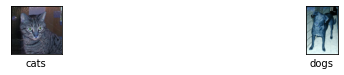

In [4]:
plt.figure(figsize=(20,10))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,5,i+1)
        plt.imshow(img_array)
        plt.xlabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        break

plt.tight_layout()        
plt.show()

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img)) 
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(training_data))

100%|██████████| 4006/4006 [00:11<00:00, 345.48it/s]

8005


In [6]:

test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(test_data))

100%|██████████| 1013/1013 [00:02<00:00, 430.97it/s]

2023


In [7]:
random.shuffle(training_data)
random.shuffle(test_data)

In [8]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (8005, 32, 32, 3) Y_train= (8005,)


In [9]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (2023, 32, 32, 3) Y_test= (2023,)


In [10]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[106.16632  115.848404 124.37849 ]


In [11]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [12]:
for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

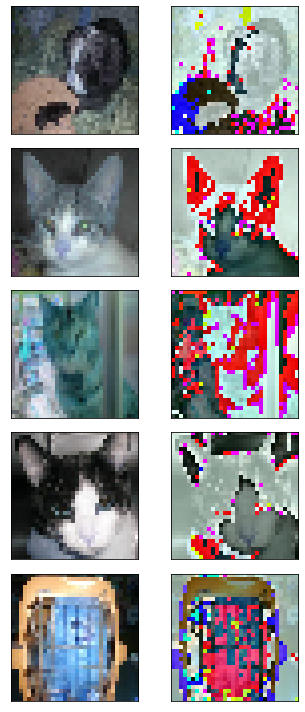

In [13]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [14]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [15]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=100, 
              validation_split=0.2,
              batch_size=128,
              callbacks=[cb]
             )

Epoch 1/100
51/51 [==============================] - 7s 18ms/step - loss: 6.3014 - accuracy: 0.4600 - val_loss: 1.1854 - val_accuracy: 0.5334
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 1.7008 - accuracy: 0.4627 - val_loss: 0.9753 - val_accuracy: 0.5409
Epoch 3/100
51/51 [==============================] - 1s 12ms/step - loss: 1.4602 - accuracy: 0.4986 - val_loss: 0.9093 - val_accuracy: 0.5553
Epoch 4/100
51/51 [==============================] - 1s 11ms/step - loss: 1.4238 - accuracy: 0.5061 - val_loss: 0.8317 - val_accuracy: 0.5703
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 1.3239 - accuracy: 0.5186 - val_loss: 0.8029 - val_accuracy: 0.5684
Epoch 6/100
51/51 [==============================] - 1s 13ms/step - loss: 1.2950 - accuracy: 0.5191 - val_loss: 0.7341 - val_accuracy: 0.6065
Epoch 7/100
51/51 [==============================] - 1s 10ms/step - loss: 1.1983 - accuracy: 0.5306 - val_loss: 0.7559 - val_accuracy: 0.5803
Epoch 

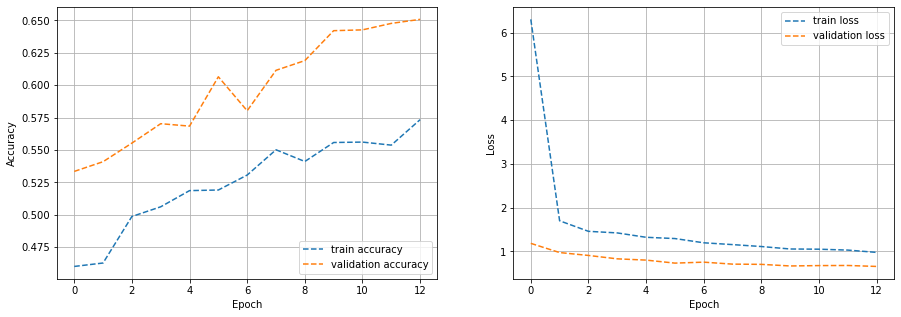

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()